Epoch [10/100], Loss: 0.0140
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0044
Epoch [40/100], Loss: 0.0057
Epoch [50/100], Loss: 0.0093
Epoch [60/100], Loss: 0.0110
Epoch [70/100], Loss: 0.0085
Epoch [80/100], Loss: 0.0073
Epoch [90/100], Loss: 0.0110
Epoch [100/100], Loss: 0.0180


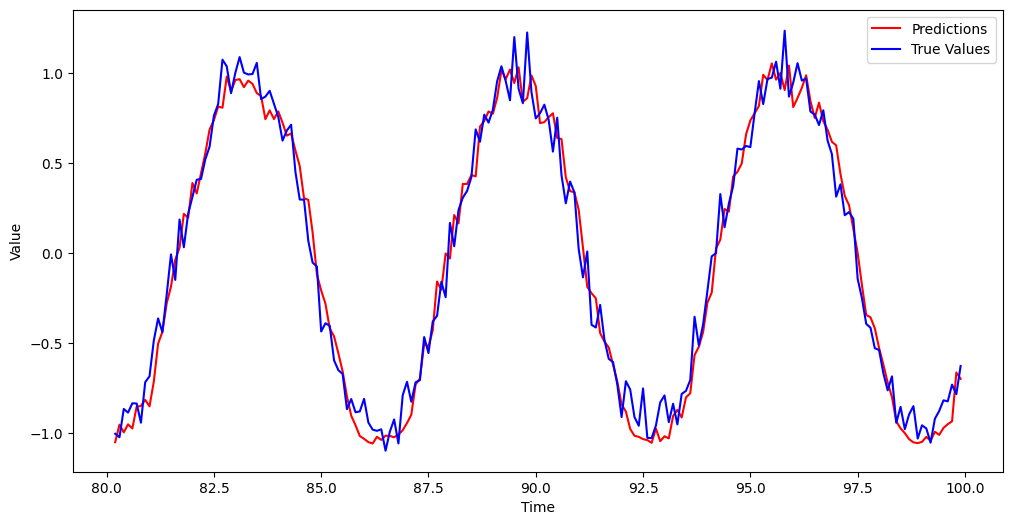

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Create a synthetic time series dataset
np.random.seed(0)
t = np.arange(0, 100, 0.1)
x = np.sin(t) + np.random.normal(0, 0.1, t.shape[0])

# Define a function to create input sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

# Hyperparameters
seq_length = 10
input_size = 1
hidden_size = 64
num_layers = 2
num_epochs = 100
learning_rate = 0.001

# Create input sequences
sequences = create_sequences(x, seq_length)

# Split data into training and testing sets
split_ratio = 0.8
split_idx = int(split_ratio * len(sequences))
train_data = sequences[:split_idx]
test_data = sequences[split_idx:]

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model and define loss and optimizer
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for sequence, target in train_data:
        sequence = torch.tensor(sequence, dtype=torch.float32).view(-1, seq_length, input_size)
        target = torch.tensor(target, dtype=torch.float32).view(-1, 1)
        output = model(sequence)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
predictions = []
targets = []

for sequence, target in test_data:
    sequence = torch.tensor(sequence, dtype=torch.float32).view(-1, seq_length, input_size)
    target = torch.tensor(target, dtype=torch.float32).view(-1, 1)
    output = model(sequence)
    predictions.append(output.item())
    targets.append(target.item())

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t[split_idx+seq_length:], predictions, label='Predictions', color='red')
plt.plot(t[split_idx+seq_length:], targets, label='True Values', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
